# LFD Homework 2

Second week homework for the "Learning from Data" course offerd by [Caltech on edX](https://courses.edx.org/courses/course-v1:CaltechX+CS1156x+3T2017). This notebook only contains the simulation / exploration problems.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

## P: Hoeffding Inequality

Task: Run a computer simulation of $10$ times simultaneously and independently flipping $1000$ virtual fair coins. Record the the following fractions of heads in these $10$ runs as

 * $\nu_1$ fraction of heads for the first coin $c_1$
 * $\nu_{\mathrm{rand}}$ fraction of heads for a randomly chosen coin $c_{\mathrm{rand}}$
 * $\nu_\min$ fraction of heads for the coin with the minimal frequency of heads $c_\min$

This can be implemented as:

In [2]:
def hfd_experiment(number_coins=1000, runs=10):
    ''' Creates one experiment of [number_coins] simultaneously flipped fair coins for [runs].'''
    coins = (np.random.rand(number_coins, runs) > .5).astype(float)
    coins_sum = coins.sum(axis=1, keepdims=True)
    
    nu_1 = coins_sum[0,0] / runs
    nu_rand = coins_sum[np.random.randint(number_coins),0] / runs
    nu_min = coins_sum[coins_sum.argmin(),0] / runs
    
    return nu_1, nu_rand, nu_min

Now the task is to repeat this experiment $100000$ times in order to get a simulated distribution of $\nu_1, \nu_{\mathrm{rand}}$ and $\nu_\min$ respectively.

In [3]:
full_distribution = np.array([hfd_experiment() for i in range(100000)])

The distributions look as follows:

<IPython.core.display.Javascript object>


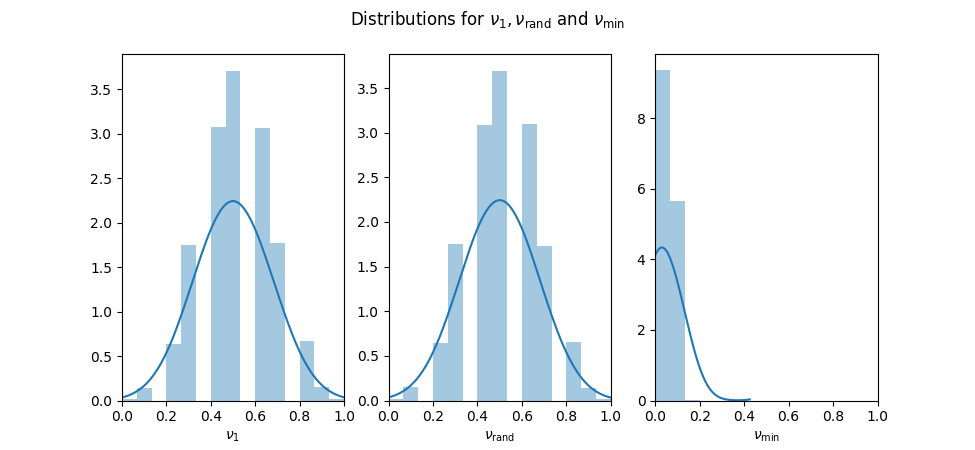

In [4]:
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(9.75, 4.5))
fig.suptitle('Distributions for $\\nu_1, \\nu_{\mathrm{rand}}$ and $\\nu_\\min$')

sns.distplot(full_distribution[:,0], bins=15, kde_kws={'bw':.075}, ax=ax[0], axlabel='$\\nu_1$')
sns.distplot(full_distribution[:,1], bins=15, kde_kws={'bw':.075}, ax=ax[1], axlabel='$\\nu_{\mathrm{rand}}$')
sns.distplot(full_distribution[:,2], bins=3, kde_kws={'bw':.075}, ax=ax[2], axlabel='$\\nu_\\min$')

for x in ax: x.set_xlim(0., 1.)

The average value of the different $\nu$ is:

In [5]:
nu_bar = full_distribution.mean(axis=0)
print('nu_1_bar\t= {:.3f}\nnu_rand_bar\t= {:.3f}\nnu_min_bar\t= {:.3f}'.format(*nu_bar))

nu_1_bar	= 0.501
nu_rand_bar	= 0.500
nu_min_bar	= 0.038


## P: Linear Regression

In this problem we use the same target function $f: \mathcal{X} \mapsto \mathcal{Y}$ as in the last homework (Perceptron). Therefore we can re-use its code (with a few cosmetic changes):

In [6]:
def generate_data(N = 10, f=None):
    ''' Generates linear target function f and labeled, linearly separable test data generated by f.'''
    
    if f is None:
        # choose two random points p1, p2 and compute a vector p orthogonal to their difference
        p1, p2 = (np.random.rand(2,2) - 0.5) * 2.
        p = np.array([1, -(p2 - p1)[0]/(p2 - p1)[1]])
        p /= np.linalg.norm(p)
    
        f = lambda x: np.sign((x - p1) @ p).reshape(-1,1)
        f.db = lambda x: (p2[1] - p1[1])/(p2[0] - p1[0]) * (x - p1[0]) + p1[1]
    
    # generate uniformely distributed data points and apply classifier to label them
    X = (np.random.rand(N, 2) - 0.5) * 2
    Y = f(X)
    
    return X,Y,f


def plot_data(X, Y, db = None):
    ''' Plots two dimensional, linearly separable data from the interval [-1, 1] and the optional decision boundary db.'''
    
    plt.figure()
    
    pos_examples = X[(Y == 1).reshape(-1)]
    neg_examples = X[(Y == -1).reshape(-1)]
    neu_examples = X[(Y == 0).reshape(-1)]
    
    # plot the three groups of examples
    plt.scatter(pos_examples[:,0], pos_examples[:,1], color='steelblue', marker='+')
    plt.scatter(neg_examples[:,0], neg_examples[:,1], color='red', marker='o')
    plt.scatter(neu_examples[:,0], neu_examples[:,1], color='black', marker='o')
    
    # plot the decision boundary if provided
    if db is not None:
        x = np.arange(-1., 1., 0.01)
        plt.plot(x, db(x), c='red', ls='dashed', lw=1.)
    
    plt.grid(alpha=.3)
    plt.gca().set_xlim(-1, 1)
    plt.gca().set_ylim(-1, 1)

Note that we provide the option to pass in the target function $f$. This will come in handy later. Now we are ready to generate some linearly separable test data for classification with linear regression or perceptrons. For instance, with $N = 100$ our functions generates:

<IPython.core.display.Javascript object>


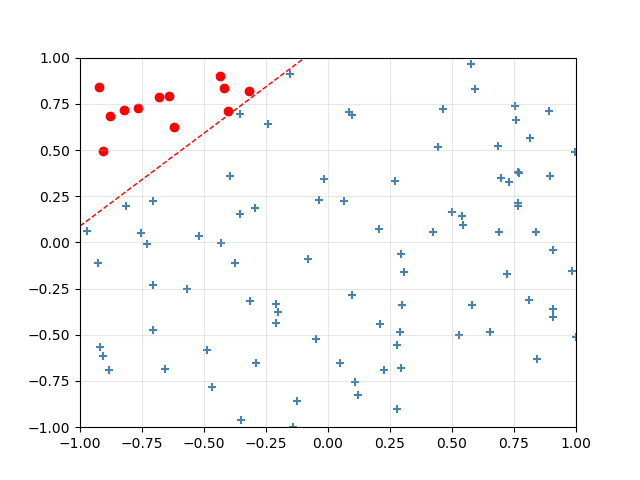

In [7]:
X, Y, f = generate_data(100)
plot_data(X, Y, f.db)

### Linear Model

The next step is to learn a linear model in the generated data. As demonstrated in the lecture, the weights of the linear model can be computed using the normal equation of the least squares method for linear regression as

$$
\mathbf{w} = \left(\mathbf{X}^\intercal\mathbf{X}\right)^{-1} \mathbf{X}^\intercal \mathbf{y}
$$

then the elected hypothesis function $g: \mathcal{X} \mapsto \mathcal{Y}$ can perform binary classification on a single example $\mathbf{x} \in \mathcal{X}$ as $g(\mathbf{x}) = \mathrm{sign}{(\mathbf{w}^\intercal\mathbf{x})}$ which can be computed for all training examples in a single run (batch computation) as

$$
h(\mathbf{X}) = \mathrm{sign}\left(\mathbf{X}\mathbf{w}\right)
$$

In [8]:
class LRBClassifier:
    ''' Simple linear regression based binary classifier.'''
    
    def __init__(self, X, Y, add_intercept=True):       
        N, d = X.shape
        if add_intercept:
            X = np.concatenate((np.ones((N, 1)), X), axis=1)
            
        self.w = np.linalg.pinv(X.T @ X) @ (X.T) @ Y
        self.E_in = np.sum(self(X, add_intercept=False) != Y)/N
    
    
    def __call__(self, X, add_intercept=True):
        N, d = X.shape
        if add_intercept:
            X = np.concatenate((np.ones((N, 1)), X), axis=1)
        
        return np.sign(X @ self.w).reshape(-1,1)

Let's test this new linear classifier with some generated data and plot what it is doing. Thereby it is particularly interesting to plot decision boundaries for $f$ and $g$. The symbol for classes is based on the actual $f$, but we highlight the decision boundary of $g$ (in red) to quickly spot classification errors. The decision boundary of $f$ is also added for reference (in gray).

<IPython.core.display.Javascript object>


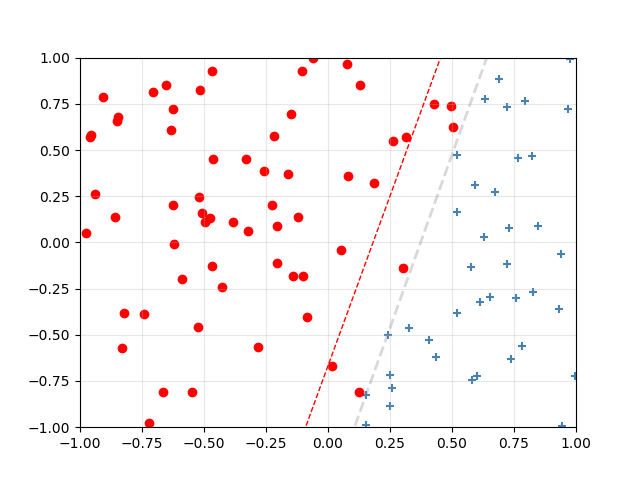

E_in = 0.060


In [9]:
X, Y, f = generate_data(100)
g = LRBClassifier(X, Y)

# we compute the decision boundary through finding an orthogonal vector to w (10e-5 term avoids division by zero)
g.db = lambda x: (- g.w[1] * x - g.w[0])/ (g.w[2] + 10e-5)
plot_data(X, Y, g.db)

# also, we can plot the actual decision boundary of f
x = np.arange(-1., 1., 0.01)
plt.plot(x, f.db(x), c='gray', ls='dashed', lw=2., alpha=.3)

print('E_in = {:.3f}'.format(g.E_in))

Now we can prepare the experiment as required by problems 5 and 6:

In [10]:
def experiment_lrbc(N=100, N_test=1000, repeat=1000, f=None, gen=generate_data):
    data = []

    for i in range(repeat):
        # generate test data and function
        X, Y, f = gen(N, f)
        
        # train a linear regression based classifier and obtain its E_in
        g = LRBClassifier(X, Y)
        E_in = g.E_in

        # obtain the out of sample error rate using the generated function f
        X_test, Y_test, _ = gen(N_test, f)
        E_out = np.sum(Y_test != g(X_test)) / float(N_test)
    
        data.append((E_in, E_out))
        if i%100 == 0:
            print('experiment (run={}): E_in={:.3f} / E_out={:.3f}'.format(i, E_in, E_out))
    
    results = np.array(data)
    print('\nAverage Errors\n--------------\nE_in\t= {:.3f}\nE_out\t= {:.3f}'.format(*np.mean(results, axis=0)))
    return results

And finally run the first experiments:

In [11]:
results = experiment_lrbc()

experiment (run=0): E_in=0.040 / E_out=0.031
experiment (run=100): E_in=0.010 / E_out=0.020
experiment (run=200): E_in=0.020 / E_out=0.043
experiment (run=300): E_in=0.010 / E_out=0.009
experiment (run=400): E_in=0.040 / E_out=0.032
experiment (run=500): E_in=0.030 / E_out=0.052
experiment (run=600): E_in=0.040 / E_out=0.052
experiment (run=700): E_in=0.030 / E_out=0.037
experiment (run=800): E_in=0.050 / E_out=0.050
experiment (run=900): E_in=0.030 / E_out=0.052

Average Errors
--------------
E_in	= 0.031
E_out	= 0.040


### Linear Model and Perceptron

Here we have to train a `LRBClassifier` and use its weights as initialization to the perceptron learning algorithm `pla`. We can recycle the perceptron learning algorithm developed in the last homework:

In [12]:
class PerceptronClassifier:
    '''Perceptron binary classifier.'''
    
    def __init__(self, X, Y, add_intercept=True, init_w=None, max_iter=10e5):       
        N, d = X.shape
        if add_intercept:
            X = np.concatenate((np.ones((N, 1)), X), axis=1)
        
        self.w = np.zeros((d+1, 1)) if init_w is None else init_w

        # perceptron learning algorithm
        X_prime, Y_prime = X.copy(), Y.copy()
        self.iterations = 0
    
        while X_prime.shape[0] > 0:
            # randomly select misclassified point
            i = np.random.randint(X_prime.shape[0])
            x_i, y_i = X_prime[i], Y_prime[i]
            
            # update hypothesis
            self.w += y_i * x_i.reshape(-1,1)
        
            # identify misclassified points
            idx = (self(X, add_intercept=False) != Y).reshape(-1)
            X_prime, Y_prime = X[idx], Y[idx]
            self.iterations += 1
        
            # divergence circuit breaker
            if self.iterations >= max_iter:
                raise StopIteration('maximum of {} iterations reached'.format(max_iter))

    
    def __call__(self, X, add_intercept=True):
        N = X.shape[0]
        if add_intercept:
            X = np.concatenate((np.ones((N, 1)), X), axis=1)
        
        return np.sign(X @ self.w).reshape(-1,1)

The experiment requires us to set $N = 10$ and find the weights using linear regression, then run the `pla` on these weights to to find a $g$ without in sample classification errors. Thereby we are interested in the number of iterations it takes the `pla` to converge:

In [13]:
def experiment_pbc_w_init(N=10, repeat=1000, f=None):
    data = []

    for i in range(repeat):
        # generate test data and function
        X, Y, f = generate_data(N, f)
        
        # train a linear regression based classifier on the data, then use this as
        # initializing weights for the pla
        g_lrbc = LRBClassifier(X, Y)
        g_pbc = PerceptronClassifier(X, Y, init_w=g_lrbc.w)

        # obtain the number of iterations until convergence for the pla
        iterations = g_pbc.iterations
        
        data.append(iterations)
        if i%100 == 0:
            print('experiment (run={}): iterations={}'.format(i, iterations))
    
    results = np.array(data)
    print('\nAverage Iterations\n------------------\nIterations\t= {}'.format(np.mean(results)))
    return results

Finally, we can run the experiment for problem 7:

In [14]:
results = experiment_pbc_w_init()

experiment (run=0): iterations=2
experiment (run=100): iterations=1
experiment (run=200): iterations=7
experiment (run=300): iterations=7
experiment (run=400): iterations=1
experiment (run=500): iterations=17
experiment (run=600): iterations=7
experiment (run=700): iterations=1
experiment (run=800): iterations=3
experiment (run=900): iterations=1

Average Iterations
------------------
Iterations	= 7.261


## P: Nonlinear Transformation

These problems again refer to the linear regression based binary classifier. The nonlinear target function is defined as

$$
f(\mathbf{x}) = \mathrm{sign}\left(x_1^2 + x_2^2 - 0.6\right)
$$

Our implementation to genrate data from above had already been prepared for passing in a target function. So all we need to do now is to implement $f$ and provide a mechanism to add some random noise to the data:

In [15]:
f = lambda X: np.sign(np.sum(X**2, axis=1, keepdims=True) - .6)

def generate_noisy_data(N = 10, f=None, noise_ratio=.1):
    '''Generates linear target function f and labeled, linearly separable test data with added noise.'''
    X, Y, f = generate_data(N, f)
    
    # add some random noise
    n_noise = np.round(noise_ratio * N).astype(int)
    idx = np.random.randint(N, size=n_noise)
    Y[idx] = -Y[idx]
    
    return X, Y, f

Let's plot this to get a feeling of what's going on:

<IPython.core.display.Javascript object>


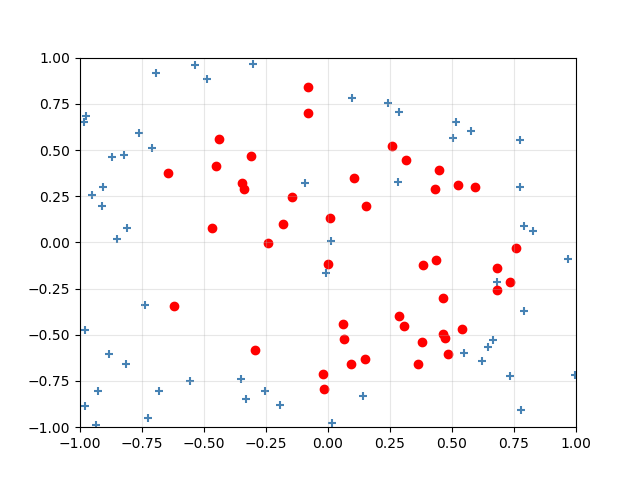

In [16]:
X, Y, _ = generate_noisy_data(100, f)
plot_data(X, Y)

Now the first task in problem 8 is to apply linear regression without any nonlinear transformation of features on a training set of size $N=1000$ and determine its in-sample error $E_{\mathrm{in}}$. Here we can re-use the experiment from above:

In [17]:
results = experiment_lrbc(N=1000, f=f, gen=generate_noisy_data)

experiment (run=0): E_in=0.473 / E_out=0.538
experiment (run=100): E_in=0.401 / E_out=0.443
experiment (run=200): E_in=0.531 / E_out=0.546
experiment (run=300): E_in=0.492 / E_out=0.479
experiment (run=400): E_in=0.538 / E_out=0.546
experiment (run=500): E_in=0.471 / E_out=0.503
experiment (run=600): E_in=0.577 / E_out=0.594
experiment (run=700): E_in=0.561 / E_out=0.547
experiment (run=800): E_in=0.484 / E_out=0.474
experiment (run=900): E_in=0.595 / E_out=0.580

Average Errors
--------------
E_in	= 0.503
E_out	= 0.519


### Applying the Nonlinear Transformation

Next we transform $\mathbf{X}$ by applying the nonlinear transformation $\Phi: \mathcal{X} \mapsto \mathcal{Z}$ which adds nonlinear features as $\Phi(\mathbf{x}) = (1, x_1, x_2, x_1 x_2, x_1^2, x_2^2)$. In the implementation we will not add the intercept feature $x_0$ as this happens already in the linear regression classifier implementation.

In [18]:
def phi(X):
    X1, X2 = np.hsplit(X, 2)
    Z = np.concatenate((X, X1 * X2, X1**2, X2**2), axis=1)
    return Z

Armed with this nonlinear transformation, we can finally prepare the last experiments:

In [19]:
def experiment_lrbc_transform(N=100, N_test=1000, repeat=1000, f=None, gen=generate_data):
    data = []
    w_acc = np.zeros((6,1))
    
    for i in range(repeat):
        # generate test data and function
        X, Y, f = gen(N, f)
        Z = phi(X)
        
        # train a linear regression based classifier and obtain its E_in
        g = LRBClassifier(Z, Y)
        w_acc += g.w
        E_in = g.E_in

        # obtain the out of sample error rate using the generated function f
        X_test, Y_test, _ = gen(N_test, f)
        Z_test = phi(X_test)
        E_out = np.sum(Y_test != g(Z_test)) / float(N_test)
    
        data.append((E_in, E_out))
        if i%100 == 0:
            print('experiment (run={}): E_in={:.3f} / E_out={:.3f}'.format(i, E_in, E_out))
    
    results = np.array(data)
    print('\nAverage Errors\n--------------\nE_in\t= {:.3f}\nE_out\t= {:.3f}'.format(*np.mean(results, axis=0)))
    return results, w_acc / repeat

Note that the arithmetic average over the weight vectors gives us a vector capturing the general direction of the weight vectors. This experiment yields:

In [20]:
results, w = experiment_lrbc_transform(N=1000, f=f, gen=generate_noisy_data)
print('\n--------------\n{:.3f} + {:.3f}x_1 + {:.3f}x_2 + {:.3f}x_1x_2 + {:.3f}x_1^2 + {:.3f}x_2^2'.format(*w.flat))

experiment (run=0): E_in=0.111 / E_out=0.105
experiment (run=100): E_in=0.118 / E_out=0.118
experiment (run=200): E_in=0.111 / E_out=0.113
experiment (run=300): E_in=0.110 / E_out=0.102
experiment (run=400): E_in=0.117 / E_out=0.120
experiment (run=500): E_in=0.110 / E_out=0.104
experiment (run=600): E_in=0.108 / E_out=0.111
experiment (run=700): E_in=0.127 / E_out=0.156
experiment (run=800): E_in=0.109 / E_out=0.111
experiment (run=900): E_in=0.108 / E_out=0.113

Average Errors
--------------
E_in	= 0.119
E_out	= 0.121

--------------
-1.006 + -0.001x_1 + -0.002x_2 + 0.002x_1x_2 + 1.576x_1^2 + 1.583x_2^2
